![](./resources/Custom_croptype_map.png)

**Study the Effect of local data**

In this notebook you will experiment the effect of local data on classification performance. 

- First we will experiment with the publicily available dataset in the region (Public datasets covering Zambia and Zimbabwe)
- Next you will add the local data provided by CIMMYT as part of the use-case exercise

**Download the prepared Public and Local data**

**Load public and local data**

The public data covering Zambia and Zimbabwe has already been queried and stored as a parquet file for your convience. You can load it by running the cell below. 

It also loads the local data covering the country you selected (CIMMYT)

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

from pathlib import Path
training_fnames = ['public_zmb_zwe.parquet', 'local_zmb.parquet', 'local_zwe.parquet']

for fname in training_fnames:
    local_file_path = Path(f"./training_data/{fname}")
    local_file_path.parent.mkdir(exist_ok=True)
    local_deploy_dict = {}
    if not local_file_path.exists():
        print(f"Downloading demo preprocessed inputs to {local_file_path}...")
        remote_url = f"https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/zambia/{fname}"
        import urllib.request
        urllib.request.urlretrieve(remote_url, local_file_path)
        
public_zmb_zwe_df = pd.read_parquet("./training_data/public_zmb_zwe.parquet")
local_country_df = pd.concat([pd.read_parquet("./training_data/local_zmb.parquet"), pd.read_parquet("./training_data/local_zwe.parquet")])

local_id_label_mapper = dict(zip(list(local_country_df['sample_id']), list(local_country_df['label_full'])))
public_id_label_mapper = dict(zip(list(public_zmb_zwe_df['sample_id']), list(public_zmb_zwe_df['label_full'])))

**Explore which datasets are included in the private dataset**

In [2]:
public_zmb_zwe_df['ref_id'].unique()

array(['2017_TZA_OSF-AFSIS_POINT_110', '2017_ZAF_JECAM-CIRAD_POLY_111',
       '2018_AF_One-Acre-Fund-MEL_POINT_110',
       '2019_TZA_CIMMYT-DM1_POINT_110',
       '2019_TZA_One-Acre-Fund-MEL_POINT_110',
       '2020_ZWE_NHI-CROP-HARVEST_POINT_110',
       '2021_GLO_EWOC-VAL_POLY_111', '2021_MOZ_FAO-WAPOR-1_POLY_111',
       '2021_TZA_COPERNICUS-GEOGLAM_POINT_110'], dtype=object)

**Check Valid time in public data**

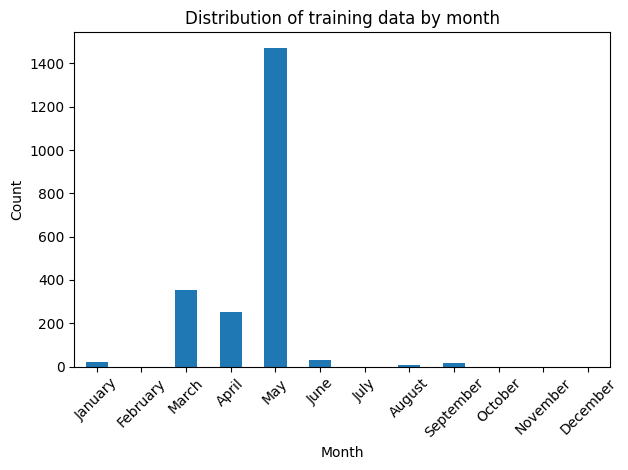

In [3]:
from notebook_utils.seasons import valid_time_distribution
valid_time_distribution(public_zmb_zwe_df)

**Check Valid time in local  data**

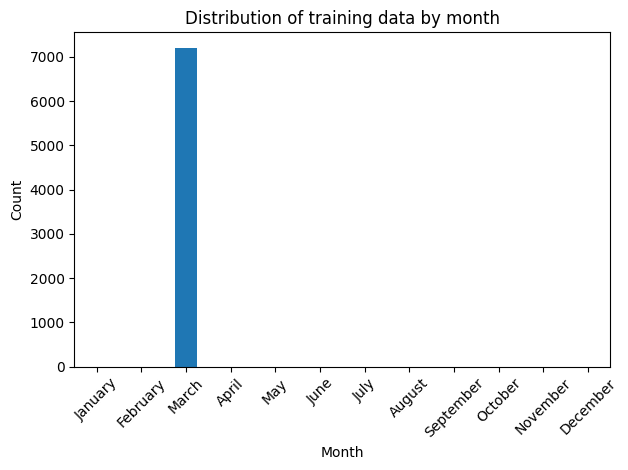

In [4]:
valid_time_distribution(local_country_df)

Using the season slider below select a window that works best given the valid time of both the public and the local data

**Set the season slider**

In [7]:
from notebook_utils.dateslider import season_slider
slider = season_slider()

In [8]:
from notebook_utils.classifier import align_extractions_to_season

season = slider.get_selected_dates()

# Align the extractions to the selected season
public_zmb_zwe_df = align_extractions_to_season(public_zmb_zwe_df, season, valid_time_buffer=2)
public_zmb_zwe_df.head()

# Align the extractions to the selected season
local_country_df = align_extractions_to_season(local_country_df, season, valid_time_buffer=2)
local_country_df.head()

2025-11-06 01:00:27.742 | INFO     | notebook_utils.dateslider:get_selected_dates:237 - Selected period: 01 Jul to 30 Jun
2025-11-06 01:00:27.743 | INFO     | worldcereal.utils.refdata:process_extractions_df:686 - Processing selected samples ...
2025-11-06 01:00:27.744 | ERROR    | worldcereal.utils.refdata:process_extractions_df:697 - Missing required column: timestamp. Please check the input data.


ValueError: Missing required column: timestamp. Please check the input data.

**Compute training features**

Using a geospatial foundation model (Presto), we derive training features for each sample in the dataframe resulting from your query. Presto was pre-trained on millions of unlabeled samples around the world and finetuned on global labelled land cover and crop type data from the WorldCereal reference database. The resulting 128 *embeddings* (`presto_ft_0` -> `presto_ft_127`) nicely condense the Sentinel-1, Sentinel-2, meteo timeseries and ancillary data for your season of interest into a limited number of meaningful features which we will use for downstream model training.<br>

We provide some options aimed at increasing temporal robustness of your final crop model.<br>
This is controlled by the following arguments:
- `augment` parameter: when set to `True`, it introduces slight temporal jittering of the processing window, making the model more robust to slight variations in seasonality across different years. By default, this option is set to `True`, but especially when training a model for a specific region and year with good local data, disabling this option could be considered.
- `mask_on_training` parameter: when `True`, applies sensor masking augmentations (e.g. simulating S1/S2 dropouts, additional clouds, ancillary feature removals) only to the training split to improve robustness to real-world data gaps. The validation/test split is  kept untouched for fair evaluation.
- `repeats` parameter: number of times each training sample is (re)drawn with its augmentations. Higher values (>1) create more variants (with jitter/masking) and enlarge the effective training set, potentially improving generalization at the cost of longer embedding inference time.

We compute the embeddings for both the public and the local data by running the cell below

In [ ]:
from notebook_utils.classifier import compute_presto_embeddings
import pandas as pd

public_zmb_zwe_df = compute_presto_embeddings(
    public_zmb_zwe_df,
    augment=True,
    mask_on_training=True,
    repeats=3
)

local_country_df = compute_presto_embeddings(
    local_country_df,
    augment=True,
    mask_on_training=True,
    repeats=3
)

**Select common crops in both public and local for fair evaluation**

In [ ]:
import pandas as pd

def drop_small_classes(df, label_col="label_full", min_count=10):
    counts = df[label_col].value_counts()
    valid_labels = counts[counts >= min_count].index
    df_filtered = df[df[label_col].isin(valid_labels)].copy()
    return df_filtered

public_zmb_zwe_df['label_full'] = public_zmb_zwe_df['sample_id'].apply(lambda x: public_id_label_mapper[x])
local_country_df['label_full'] = local_country_df['sample_id'].apply(lambda x: local_id_label_mapper[x])

public_zmb_zwe_df = drop_small_classes(public_zmb_zwe_df)
local_country_df = drop_small_classes(local_country_df)

common_labels = set(public_zmb_zwe_df['label_full'].unique()) & set(local_country_df['label_full'].unique())

public_zmb_zwe_df = public_zmb_zwe_df[public_zmb_zwe_df['label_full'].isin(common_labels)].copy()
local_country_df = local_country_df[local_country_df['label_full'].isin(common_labels)].copy()

print(f"Number of common labels: {len(common_labels)}")
print("Common crops for which the model will be trained:", sorted(common_labels))

In [ ]:
crops_to_keep = {'maize', 'unspecified_millet', 'unspecified_sorghum'}
crops_to_keep = {}  # example for empty set

if crops_to_keep:
    local_country_df.loc[~local_country_df['label_full'].isin(crops_to_keep), 'label_full'] = 'others'
    public_zmb_zwe_df.loc[~public_zmb_zwe_df['label_full'].isin(crops_to_keep), 'label_full'] = 'others'
else: 
    pass

**Create and indenpendent test set from the local data**

In [ ]:
train_local_country, test_local_country = train_test_split(
    local_country_df,
    test_size=0.2,
    stratify=local_country_df["label_full"],
    random_state=42
)

print("Public dataset:", len(public_zmb_zwe_df), "train,")
print("Local Zambia dataset:", len(train_local_country), "train,", len(test_local_country), "test")

**Add a downstream class column**

In [ ]:
public_zmb_zwe_df['downstream_class'] = public_zmb_zwe_df['label_full']
train_local_country['downstream_class'] = train_local_country['label_full']
test_local_country['downstream_class'] = test_local_country['label_full']

**Train a classifier on the PUBLIC dataset alone**

In [ ]:
from notebook_utils.classifier import train_classifier

custom_model_pub, report, confusion_matrix = train_classifier(
    public_zmb_zwe_df, balance_classes=True, show_confusion_matrix='absolute',
)
print(report)

**Train a classifier on PUBLIC + LOCAL dataset alone**

In [ ]:
from notebook_utils.classifier import train_classifier

custom_model_pub_loc, report, confusion_matrix = train_classifier(
    pd.concat([public_zmb_zwe_df, train_local_country]), balance_classes=True, show_confusion_matrix='absolute',
)
print(report)

**Evaluate PUBLIC Model on independent LOCAL test data**

In [ ]:
from notebook_utils.classifier import train_classifier, apply_classifier
test_report_public, test_cm_public, _ = apply_classifier(
    test_local_country,
    custom_model_pub,
    show_confusion_matrix='absolute',
)

**Evaluate PUBLIC + LOCAL Model on independent LOCAL test data**

In [ ]:
from notebook_utils.classifier import train_classifier, apply_classifier
test_report_pub_loc, test_cm_pub_loc, _ = apply_classifier(
    test_local_country,
    custom_model_pub_loc,
    show_confusion_matrix='absolute',
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from notebook_utils.classifier import train_classifier, apply_classifier

def create_fewshot_groups(train_local_country, label_col="label_full", ks=[1, 5, 10, 20, "all"], random_state=42):
    fewshot_groups = {}
    grouped = train_local_country.groupby(label_col)
    
    for k in ks:
        if k == "all":
            fewshot_groups[k] = train_local_country.copy()
        else:
            sampled_df = grouped.apply(lambda x: x.sample(min(len(x), k), random_state=42)).reset_index(drop=True)
            fewshot_groups[k] = sampled_df
    
    return fewshot_groups


def run_fewshot_experiment(fewshot_groups, test_df, balance_classes=True):
    results = []
    crop_counts = {}
    
    for k, train_df in fewshot_groups.items():
        print(f"\n=== Running {k}-shot setting ({len(train_df)} samples) ===")
        crop_counts[k] = train_df['label_full'].value_counts().to_dict()
        print(crop_counts)
        custom_model_loc, report, _ = train_classifier(
            train_df,
            balance_classes=balance_classes,
            show_confusion_matrix="absolute"
        )
        
        test_report, _, _ = apply_classifier(
            test_df,
            custom_model_loc,
            show_confusion_matrix="absolute"
        )
        
        row = {"samples": k}
        for label, metrics in test_report.items():
            if isinstance(metrics, dict) and "f1-score" in metrics:
                row[label] = metrics["f1-score"]
        if "accuracy" in test_report:
            row["overall_accuracy"] = test_report["accuracy"]
        results.append(row)
    
    results_df = pd.DataFrame(results)
    return results_df, crop_counts


def plot_fewshot_results(results_df, crop_counts):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = [int(k) if k != "all" else max([v for v in results_df["samples"] if v != "all"]) * 1.1
         for k in results_df["samples"]]
    
    exclude = {"macro avg", "weighted avg", "overall_accuracy"}
    crop_cols = [c for c in results_df.columns if c not in exclude and c != "samples"]

    for crop in crop_cols:
        ax.plot(x, results_df[crop], marker="o", label=crop, alpha=0.6, linestyle="--")

    if "overall_accuracy" in results_df.columns:
        ax.plot(x, results_df["overall_accuracy"], marker="o", color="black", linewidth=2, label="Overall Accuracy")

    ax.set_xscale("log")
    ax.set_xlabel("Samples per Class (Few-shot setting)")
    ax.set_ylabel("F1-score / Accuracy")
    ax.set_title("Few-shot Performance per Crop and Overall")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True, linestyle=":")
    plt.tight_layout()

    count_table = pd.DataFrame(crop_counts).fillna(0).astype(int)
    count_table.index.name = "Crop"
    count_table = count_table.reset_index()
    print("\nActual samples used per crop and few-shot setting:\n")
    display(count_table)

    plt.show()


**Run sample count based experiments**

In [ ]:
ks = (10, 50, 100, 200, 'all') #'all' will use all the available local data for that crop

In [ ]:
fewshot_groups = create_fewshot_groups(train_local_country, label_col="label_full", ks=ks, random_state=42)
results_df, crop_counts = run_fewshot_experiment(fewshot_groups, test_local_country, balance_classes=True)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_fewshot_results(results_df, crop_counts):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    results_df["samples"] = results_df["samples"].astype(str)
    x = []
    for k in results_df["samples"]:
        if k == "all":
            max_val = max([int(v) for v in results_df["samples"] if v.isdigit()])
            x.append(max_val * 1.1)
        else:
            x.append(int(k))
    
    exclude = {"macro avg", "weighted avg", "overall_accuracy"}
    crop_cols = [c for c in results_df.columns if c not in exclude and c != "samples"]

    for crop in crop_cols:
        ax.plot(x, results_df[crop], marker="o", label=crop, alpha=0.6, linestyle="--")

    if "overall_accuracy" in results_df.columns:
        ax.plot(x, results_df["overall_accuracy"], marker="o", color="black", linewidth=2, label="Overall Accuracy")

    ax.set_xscale("linear")
    ax.set_xlabel("Samples per Class (Few-shot setting)")
    ax.set_ylabel("F1-score / Accuracy")
    ax.set_title("Few-shot Performance per Crop and Overall")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True, linestyle=":")
    ax.set_ylim(bottom=0)
    plt.tight_layout()

    count_table = pd.DataFrame(crop_counts).fillna(0).astype(int)
    count_table.index.name = "Crop"
    count_table = count_table.reset_index()
    print("\nActual samples used per crop and few-shot setting:\n")
    display(count_table)

    plt.show()

row_pub = {"samples": 0}
for label, metrics in test_report_public.items():
    if isinstance(metrics, dict) and "f1-score" in metrics:
        row_pub[label] = metrics["f1-score"]
if "accuracy" in test_report_public:
    row_pub["overall_accuracy"] = test_report_public["accuracy"]

results_df = pd.concat([pd.DataFrame([row_pub]), results_df], ignore_index=True)

zero_counts = {label: 0 for label in crop_counts[next(iter(crop_counts))].keys()}
crop_counts = {0: zero_counts, **crop_counts}

results_df["samples"] = pd.Categorical(
    results_df["samples"],
    categories=[0] + [k for k in results_df["samples"] if k not in [0, "all"]] + ["all"],
    ordered=True
)

plot_fewshot_results(results_df, crop_counts)


**You have reached the end of the notebook**